### Import Libraries

In [54]:
import pandas as pd
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import json
import re
from pandas import Series, DataFrame
import numpy as np
import nltk
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import grid_search
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import gzip
import shutil
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.contrib import learn
import os
import sys
import time
import logging
import tensorflow as tf
from sklearn.cross_validation import KFold
from sklearn.externals import joblib
import pickle

# importing libraries which will be used to plot graphs
%matplotlib inline
plt.style.use('seaborn-darkgrid')

# Logging conditions
logging.getLogger().setLevel(logging.INFO)
# Stemming 
stemmer = WordNetLemmatizer()

In [3]:
def convertFileIntoJSON(fileName):
    """
    :type s: str
    :rtype: JSON
    """
    if fileName.endswith('.gz'):
        with gzip.open(fileName, 'rb') as f_in, open(fileName[:-3], 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)
    
    return fileName[:-3]

In [4]:
# Reading the data
tf_train = pd.read_json(convertFileIntoJSON('cuisine.train.json.gz'))
tf_dev = pd.read_json(convertFileIntoJSON('cuisine.dev.json.gz'))
tf_test = pd.read_json(convertFileIntoJSON('cuisine.unlabeled.json.gz'))

In [5]:
# Sample data
tf_train.head(5)

,cuisine,id,ingredients
0,italian,0,"[chicken bouillon granules, olive oil, garlic,..."
1,russian,1,"[semolina, raisins, eggs, flour, cottage chees..."
2,british,2,"[mincemeat, pie crust, large egg yolks]"
3,mexican,3,"[chopped tomatoes, green onions, onions, red c..."
4,thai,4,"[coconut oil, shrimp paste, sea salt, galangal..."


In [6]:
# Our classes
tf_train.cuisine.unique()

array(['italian', 'russian', 'british', 'mexican', 'thai', 'southern_us',
       'vietnamese', 'chinese', 'cajun_creole', 'brazilian', 'korean',
       'french', 'indian', 'moroccan', 'greek', 'jamaican', 'filipino',
       'irish', 'spanish', 'japanese'], dtype=object)

### Data Cleaning 

In [8]:
def data_preprocess(tfData):
    """
    :type s: DataFrame
    :rtype: DataFrma
    """
    def clean_recipe(recipe):
        # To lowercase
        recipe = [ str.lower(i) for i in recipe ]

        # Remove some special characters and digits
        # Stem ingredients
        return ' '.join([stemmer.lemmatize(re.sub('[^a-z]', ' ', item)) for item in recipe]).strip()
    
    tfData['ingredients_string'] = [clean_recipe(recipe) for recipe in tfData['ingredients']]
    return tfData

In [9]:
tf_train_data = data_preprocess(tf_train)
tf_dev_data = data_preprocess(tf_dev)
tf_test_data = data_preprocess(tf_test)

In [11]:
# Cleaned dataframe sample (Adding a new column 'ingredients_string')
tf_train_data.head(5)

,cuisine,id,ingredients,ingredients_string
0,italian,0,"[chicken bouillon granules, olive oil, garlic,...",chicken bouillon granules olive oil garlic bon...
1,russian,1,"[semolina, raisins, eggs, flour, cottage chees...",semolina raisin egg flour cottage cheese butte...
2,british,2,"[mincemeat, pie crust, large egg yolks]",mincemeat pie crust large egg yolks
3,mexican,3,"[chopped tomatoes, green onions, onions, red c...",chopped tomatoes green onions onion red chile ...
4,thai,4,"[coconut oil, shrimp paste, sea salt, galangal...",coconut oil shrimp paste sea salt galangal lim...


### Vectorizing Data

In [12]:
# TF-IDF Vectorizer
vectorizertr = TfidfVectorizer(stop_words='english',
                             ngram_range = ( 1 , 1 ), analyzer="word", 
                             max_df = .5 , binary=True, token_pattern=r'\w+' , sublinear_tf=False)

# Train data
corpustr = tf_train_data['ingredients_string']
tfidftr=vectorizertr.fit_transform(corpustr).todense()
train_X = tfidftr
train_y = tf_train_data['cuisine']
with open('vectorizer.pk', 'wb') as fin:
    pickle.dump(vectorizertr, fin)

# Dev data
corpusdev = tf_dev_data['ingredients_string']
tfidfdev=vectorizertr.transform(corpusdev)
dev_X = tfidfdev
dev_y = tf_dev_data['cuisine']


# Test data
corpusts = tf_test_data['ingredients_string']
tfidfts=vectorizertr.transform(corpusts)
test_X = tfidfts

### Report Generator

In [60]:
# Populate a report on Dev Set for a classifier
def generateFullReportForDevSet(clf, type_classifier):
    y_pred_dev = clf.predict(dev_X)
    
    print("** Accuracy for Dev Set {0}... **".format(accuracy_score(dev_y, y_pred_dev)))

    print("\n\tReport created for {0} model:\n\n".format(type_classifier))

    print(classification_report(dev_y, y_pred_dev))
    createConfusionMatrixBar(dev_y, y_pred_dev)

In [24]:
# Analyze the confusion matrix on a bar graph...
def createConfusionMatrixBar(y_test, y_pred):

    plt.figure(figsize=(10, 10))

    cm = confusion_matrix(y_test, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm_normalized, interpolation='nearest')
    plt.title("confusion matrix")
    plt.colorbar(shrink=0.3)
    cuisines = tf_dev_data['cuisine'].value_counts().index
    tick_marks = np.arange(len(cuisines))
    plt.xticks(tick_marks, cuisines, rotation=90)
    plt.yticks(tick_marks, cuisines)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### Logistic Regression

In [17]:
def runLogisticRegression():

    training_acc = []
    accuracy = []
    
    # Kfold Cross validation
    kf = KFold(train_X.shape[0], n_folds=10, shuffle=True)
    #Build the model and train it.
    print("The logistic regression model is training...")
    clf = LogisticRegression()
    parameters = {'C':[1, 10]}

    for train, test in kf:
        X_Train, X_Test = train_X[train], train_X[test]
        Y_Train, Y_Test = train_y[train], train_y[test]

        logreg = grid_search.GridSearchCV(clf, parameters)
        logreg.fit(X_Train,Y_Train)
        # print model.score(X_Train,Y_Train)
        y_pred = logreg.predict(X_Test)

        training_acc.append(accuracy_score(Y_Train, logreg.predict(X_Train)))
        accuracy.append(accuracy_score(Y_Test, y_pred))

    logging.info("Training Accuracy of Logistic regression is {}".format(np.asarray(training_acc).mean()))
    logging.info("Validation Accuracy of Logistic regression is {}".format(np.asarray(accuracy).mean()))
    
    joblib.dump(logreg, 'yummly_lg.pkl') 

    print("The logistic regression model is saved in 'yumly_lg.pkl'")
    
    return logreg

logreg = runLogisticRegression()

The logistic regression model is training...


INFO:root:Training Accuracy of Logistic regression is 0.8683490954221373
INFO:root:Validation Accuracy of Logistic regression is 0.789339595109318


The logistic regression model is saved in 'yumly_lg.pkl'


** Accuracy for Dev Set 0.6691389063482087... **

	Report created for Logistic Regression model:


              precision    recall  f1-score   support

   brazilian       0.75      0.55      0.63        97
     british       0.62      0.47      0.54       159
cajun_creole       0.77      0.70      0.73       304
     chinese       0.01      0.01      0.01       532
    filipino       0.75      0.57      0.65       132
      french       0.61      0.66      0.63       527
       greek       0.78      0.72      0.74       226
      indian       0.00      0.00      0.00       592
       irish       0.64      0.44      0.52       133
     italian       0.83      0.90      0.86      1575
    jamaican       0.84      0.68      0.75       126
    japanese       0.80      0.73      0.76       280
      korean       0.82      0.81      0.82       154
     mexican       0.89      0.92      0.91      1291
    moroccan       0.76      0.73      0.75       146
     russian       0.60      0.39   

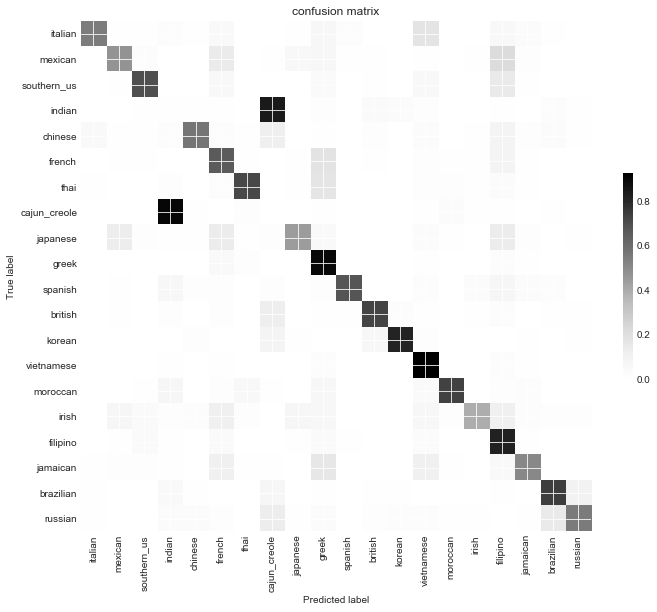

In [61]:
generateFullReportForDevSet(logreg, "Logistic Regression")

### Random Forests 

In [27]:
# This could take few minutes to run.... 
def runRandomForests():

    training_acc = []
    accuracy = []

    # Kfold Cross validation
    kf = KFold(train_X.shape[0], n_folds=10, shuffle=True)
    #Build the model and train it.
    print("The random forests model is training...")
    rf_clf = RandomForestClassifier(random_state=42, criterion = 'gini', n_estimators=100)

    for train, test in kf:
        X_Train, X_Test = train_X[train], train_X[test]
        Y_Train, Y_Test = train_y[train], train_y[test]

        rf_clf.fit(X_Train, Y_Train)
        
        y_pred = rf_clf.predict(X_Test)

        training_acc.append(accuracy_score(Y_Train, rf_clf.predict(X_Train)))
        accuracy.append(accuracy_score(Y_Test, y_pred))
        

    logging.info("Training Accuracy of Random Forests is {}".format(np.asarray(training_acc).mean()))
    logging.info("Validation Accuracy of Random Forests is {}".format(np.asarray(accuracy).mean()))
    
    joblib.dump(rf_clf, 'yummly_rf.pkl') 
    
    print("The randomforest model is saved in 'yumly_rf.pkl'")
    
    return rf_clf

rndForest = runRandomForests()

The random forest model is training...


INFO:root:Training Accuracy of Random Forests is 0.9996508026301161
INFO:root:Validation Accuracy of Random Forests is 0.748295070254305


The randomforest model is saved in 'yumly_rf.pkl'


** Accuracy for Dev Set 0.613073538654934... **

	Report created for Random Forests model:


              precision    recall  f1-score   support

   brazilian       0.82      0.43      0.57        97
     british       0.75      0.28      0.40       159
cajun_creole       0.79      0.62      0.70       304
     chinese       0.00      0.01      0.01       532
    filipino       0.75      0.51      0.61       132
      french       0.56      0.48      0.51       527
       greek       0.83      0.53      0.65       226
      indian       0.00      0.00      0.00       592
       irish       0.68      0.29      0.40       133
     italian       0.69      0.91      0.78      1575
    jamaican       0.92      0.44      0.60       126
    japanese       0.84      0.66      0.74       280
      korean       0.86      0.63      0.73       154
     mexican       0.84      0.92      0.88      1291
    moroccan       0.89      0.62      0.73       146
     russian       0.65      0.12      0.2

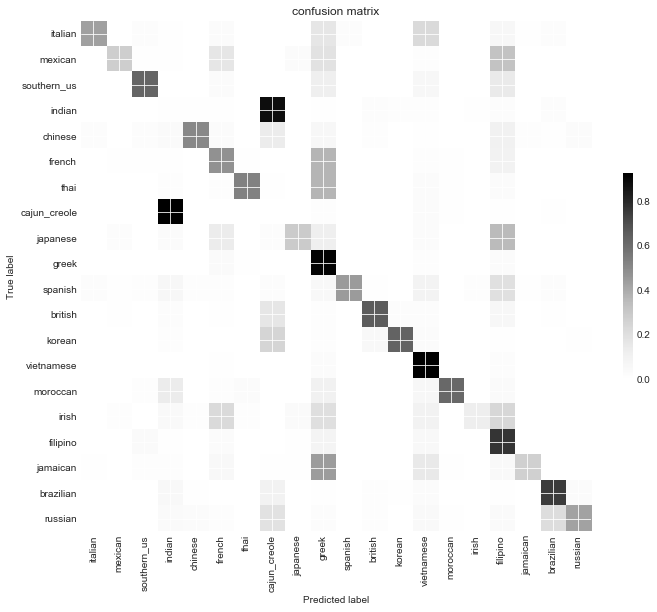

In [62]:
generateFullReportForDevSet(rndForest, "Random Forests")

In [29]:
def clean_recipe(recipe):
    # To lowercase
    recipe = [ str.lower(i) for i in recipe ]

    # Remove some special characters and digits
    # Stem ingredients
    return ' '.join([stemmer.lemmatize(re.sub('[^a-z]', ' ', item)) for item in recipe]).strip()

def load_data_and_labels(df):
    # Map the actual labels to one hot labels
    labels = sorted(list(set(df['cuisine'].tolist())))
    one_hot = np.zeros((len(labels), len(labels)), int)
    np.fill_diagonal(one_hot, 1)
    label_dict = dict(zip(labels, one_hot))

    x = df['ingredients'].apply(lambda x: clean_recipe(x)).tolist()
    y = df['cuisine'].apply(lambda y: label_dict[y]).tolist()
    return x, y, labels

def load_test_data(df):
    # Map the actual labels to one hot labels

    x = df['ingredients'].apply(lambda x: clean_recipe(x)).tolist()
    return x

def batch_iter(data, batch_size, num_epochs, shuffle=True):
    """Iterate the data batch by batch"""
    data = np.array(data)
    data_size = len(data)
    num_batches_per_epoch = int(data_size / batch_size) + 1

    for epoch in range(num_epochs):
        if shuffle:
            shuffle_indices = np.random.permutation(np.arange(data_size))
            shuffled_data = data[shuffle_indices]
        else:
            shuffled_data = data

        for batch_num in range(num_batches_per_epoch):
            start_index = batch_num * batch_size
            end_index = min((batch_num + 1) * batch_size, data_size)
            yield shuffled_data[start_index:end_index]

In [40]:
params = {
            "num_epochs": 50,
            "batch_size": 32,
            "num_filters": 64,
            "filter_sizes": "2,3,5",
            "embedding_dim": 128,
            "l2_reg_lambda": 1e-4,
            "evaluate_every": 100,
            "dropout_keep_prob": 0.5
          }

In [42]:
class TextCNN(object):
    def __init__(self, sequence_length, num_classes, vocab_size, embedding_size, filter_sizes, num_filters, l2_reg_lambda=0.0):
        # Placeholders for input, output and dropout
        self.input_x = tf.placeholder(tf.int32, [None, sequence_length], name='input_x')
        self.input_y = tf.placeholder(tf.float32, [None, num_classes], name='input_y')
        self.dropout_keep_prob = tf.placeholder(tf.float32, name='dropout_keep_prob')

        # Keeping track of l2 regularization loss (optional)
        l2_loss = tf.constant(0.0)

        # Embedding layer
        with tf.device('/cpu:0'), tf.name_scope('embedding'):
            W = tf.Variable(tf.random_uniform([vocab_size, embedding_size], -1.0, 1.0), name='W')
            self.embedded_chars = tf.nn.embedding_lookup(W, self.input_x)
            self.embedded_chars_expanded = tf.expand_dims(self.embedded_chars, -1)

        # Create a convolution + maxpool layer for each filter size
        pooled_outputs = []
        for i, filter_size in enumerate(filter_sizes):
            with tf.name_scope('conv-maxpool-%s' % filter_size):
                # Convolution Layer
                filter_shape = [filter_size, embedding_size, 1, num_filters]
                W = tf.Variable(tf.truncated_normal(filter_shape, stddev=0.1), name='W')
                b = tf.Variable(tf.constant(0.1, shape=[num_filters]), name='b')
                conv = tf.nn.conv2d(
                    self.embedded_chars_expanded,
                    W,
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name='conv')

                # Apply nonlinearity
                h = tf.nn.relu(tf.nn.bias_add(conv, b), name='relu')

                # Maxpooling over the outputs
                pooled = tf.nn.max_pool(
                    h,
                    ksize=[1, sequence_length - filter_size + 1, 1, 1],
                    strides=[1, 1, 1, 1],
                    padding='VALID',
                    name='pool')
                pooled_outputs.append(pooled)

        # Combine all the pooled features
        num_filters_total = num_filters * len(filter_sizes)
        self.h_pool = tf.concat(pooled_outputs,3)
        self.h_pool_flat = tf.reshape(self.h_pool, [-1, num_filters_total])

        # Add dropout
        with tf.name_scope('dropout'):
            self.h_drop = tf.nn.dropout(self.h_pool_flat, self.dropout_keep_prob)

        # Final (unnormalized) scores and predictions
        with tf.name_scope('output'):
            W = tf.get_variable(
                'W',
                shape=[num_filters_total, num_classes],
                initializer=tf.contrib.layers.xavier_initializer())
            b = tf.Variable(tf.constant(0.1, shape=[num_classes]), name='b')
            l2_loss += tf.nn.l2_loss(W)
            l2_loss += tf.nn.l2_loss(b)
            self.scores = tf.nn.xw_plus_b(self.h_drop, W, b, name='scores')  # tf.nn.xw_plus_b(self.h_drop, W, b, name='scores')
            self.predictions = tf.argmax(self.scores, 1, name='predictions')
            self.probs = tf.nn.softmax(tf.matmul(self.h_drop, W) + b, name='probs') # Softmax

        # Calculate mean cross-entropy loss
        with tf.name_scope('loss'):
            losses = tf.nn.softmax_cross_entropy_with_logits(labels = self.input_y, logits = self.scores)         
            self.loss = tf.reduce_mean(losses) + l2_reg_lambda * l2_loss

        # Accuracy
        with tf.name_scope('accuracy'):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_predictions, 'float'), name='accuracy')
        
        # Number of correct predictions
        with tf.name_scope('num_correct'):
            correct_predictions = tf.equal(self.predictions, tf.argmax(self.input_y, 1))
            self.num_correct = tf.reduce_sum(tf.cast(correct_predictions, 'float'), name='num_correct')

In [41]:
def CNN_training():
    x_raw, y_raw, labels = load_data_and_labels(tf_train)

    """Step 1: pad each sentence to the same length and map each word to an id"""
    max_document_length = max([len(x.split(' ')) for x in x_raw])
    logging.info('The maximum length of all sentences: {}'.format(max_document_length))
    vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length)
    x = np.array(list(vocab_processor.fit_transform(x_raw)))
    y = np.array(y_raw)
    
    """Step 2: split the original dataset into train and test sets"""
    x_, x_test, y_, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

    """Step 3: shuffle the train set and split the train set into train and dev sets"""
    shuffle_indices = np.random.permutation(np.arange(len(y_)))
    x_shuffled = x_[shuffle_indices]
    y_shuffled = y_[shuffle_indices]
    x_train, x_val, y_train, y_val = train_test_split(x_shuffled, y_shuffled, test_size=0.1)

    """Step 4: save the labels into labels.json since predict.py needs it"""
    with open('./labels.json', 'w') as outfile:
        json.dump(labels, outfile, indent=4)

    logging.info('x_train: {}, x_val: {}, x_test: {}'.format(len(x_train), len(x_val), len(x_test)))
    logging.info('y_train: {}, y_val: {}, y_test: {}'.format(len(y_train), len(y_val), len(y_test)))
    
    """Step 5: build a graph and cnn object"""
    graph = tf.Graph()
    with graph.as_default():
        session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
        sess = tf.Session(config=session_conf)
        with sess.as_default():
            cnn = TextCNN(
                sequence_length=x_train.shape[1],
                num_classes=y_train.shape[1],
                vocab_size=len(vocab_processor.vocabulary_),
                embedding_size=params['embedding_dim'],
                filter_sizes=list(map(int, params['filter_sizes'].split(","))),
                num_filters=params['num_filters'],
                l2_reg_lambda=params['l2_reg_lambda'])

            global_step = tf.Variable(0, name="global_step", trainable=False)
            optimizer = tf.train.AdamOptimizer(1e-3)
            grads_and_vars = optimizer.compute_gradients(cnn.loss)
            train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

            timestamp = str(int(time.time()))
            out_dir = os.path.abspath(os.path.join(os.path.curdir, "trained_model_" + timestamp))

            checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
            checkpoint_prefix = os.path.join(checkpoint_dir, "model")
            if not os.path.exists(checkpoint_dir):
                os.makedirs(checkpoint_dir)
            saver = tf.train.Saver(tf.global_variables())

            # One training step: train the model with one batch
            def train_step(x_batch, y_batch):
                feed_dict = {
                    cnn.input_x: x_batch,
                    cnn.input_y: y_batch,
                    cnn.dropout_keep_prob: params['dropout_keep_prob']}
                _, step, loss, acc = sess.run([train_op, global_step, cnn.loss, cnn.accuracy], feed_dict)

            # One evaluation step: evaluate the model with one batch
            def val_step(x_batch, y_batch):
                feed_dict = {cnn.input_x: x_batch, cnn.input_y: y_batch, cnn.dropout_keep_prob: 1.0}
                step, loss, acc, num_correct = sess.run([global_step, cnn.loss, cnn.accuracy, cnn.num_correct], feed_dict)
                return num_correct

            # Save the word_to_id map since predict.py needs it
            vocab_processor.save(os.path.join(out_dir, "vocab.pickle"))
            sess.run(tf.global_variables_initializer())

            # Training starts here
            train_batches = batch_iter(list(zip(x_train, y_train)), params['batch_size'], params['num_epochs'])
            best_accuracy, best_at_step = 0, 0

            """Step 6: train the cnn model with x_train and y_train (batch by batch)"""
            for train_batch in train_batches:
                x_train_batch, y_train_batch = zip(*train_batch)
                train_step(x_train_batch, y_train_batch)
                current_step = tf.train.global_step(sess, global_step)

                """Step 6.1: evaluate the model with x_val and y_val (batch by batch)"""
                if current_step % params['evaluate_every'] == 0:
                    val_batches = batch_iter(list(zip(x_val, y_val)), params['batch_size'], 1)
                    total_val_correct = 0
                    for val_batch in val_batches:
                        x_val_batch, y_val_batch = zip(*val_batch)
                        num_val_correct = val_step(x_val_batch, y_val_batch)
                        total_val_correct += num_val_correct

                    val_accuracy = float(total_val_correct) / len(y_val)
                    logging.info('Accuracy on dev set: {}'.format(val_accuracy))

                    """Step 6.2: save the model if it is the best based on accuracy on dev set"""
                    if val_accuracy >= best_accuracy:
                        best_accuracy, best_at_step = val_accuracy, current_step
                        path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                        logging.info('Saved model at {} at step {}'.format(path, best_at_step))
                        logging.info('Best accuracy is {} at step {}'.format(best_accuracy, best_at_step))

            """Step 7: predict x_test (batch by batch)"""
            test_batches = batch_iter(list(zip(x_test, y_test)), params['batch_size'], 1)
            total_test_correct = 0
            for test_batch in test_batches:
                x_test_batch, y_test_batch = zip(*test_batch)
                num_test_correct = val_step(x_test_batch, y_test_batch)
                total_test_correct += num_test_correct

            test_accuracy = float(total_test_correct) / len(y_test)
            logging.info('Accuracy on test set is {} based on the best model {}'.format(test_accuracy, path))
            logging.info('The training is complete')

In [43]:
CNN_training()

INFO:root:The maximum length of all sentences: 142
INFO:root:x_train: 25773, x_val: 2864, x_test: 3182
INFO:root:y_train: 25773, y_val: 2864, y_test: 3182
INFO:root:Accuracy on dev set: 0.41829608938547486
INFO:root:Saved model at /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517200260/checkpoints/model-100 at step 100
INFO:root:Best accuracy is 0.41829608938547486 at step 100
INFO:root:Accuracy on dev set: 0.5066340782122905
INFO:root:Saved model at /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517200260/checkpoints/model-200 at step 200
INFO:root:Best accuracy is 0.5066340782122905 at step 200
INFO:root:Accuracy on dev set: 0.5467877094972067
INFO:root:Saved model at /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517200260/checkpoints/model-300 at step 300
INFO:root:Best accuracy is 0.5467877094972067 at step 300
INFO:root:Accuracy on dev set: 0.5754189944134078
INFO:root:Saved model at /Users/clearaccessip/Desktop/Interview/Yummly/trained_

INFO:root:Accuracy on dev set: 0.7611731843575419
INFO:root:Accuracy on dev set: 0.7657122905027933
INFO:root:Accuracy on dev set: 0.755586592178771
INFO:root:Accuracy on dev set: 0.7667597765363129
INFO:root:Saved model at /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517200260/checkpoints/model-5100 at step 5100
INFO:root:Best accuracy is 0.7667597765363129 at step 5100
INFO:root:Accuracy on dev set: 0.7664106145251397
INFO:root:Accuracy on dev set: 0.7681564245810056
INFO:root:Saved model at /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517200260/checkpoints/model-5300 at step 5300
INFO:root:Best accuracy is 0.7681564245810056 at step 5300
INFO:root:Accuracy on dev set: 0.770949720670391
INFO:root:Saved model at /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517200260/checkpoints/model-5400 at step 5400
INFO:root:Best accuracy is 0.770949720670391 at step 5400
INFO:root:Accuracy on dev set: 0.7653631284916201
INFO:root:Accuracy on dev set:

INFO:root:Accuracy on dev set: 0.7664106145251397
INFO:root:Accuracy on dev set: 0.7692039106145251
INFO:root:Accuracy on dev set: 0.770949720670391
INFO:root:Accuracy on dev set: 0.7719972067039106
INFO:root:Accuracy on dev set: 0.7695530726256983
INFO:root:Accuracy on dev set: 0.7685055865921788
INFO:root:Accuracy on dev set: 0.7695530726256983
INFO:root:Accuracy on dev set: 0.7685055865921788
INFO:root:Accuracy on dev set: 0.7667597765363129
INFO:root:Accuracy on dev set: 0.7618715083798883
INFO:root:Accuracy on dev set: 0.7622206703910615
INFO:root:Accuracy on dev set: 0.7674581005586593
INFO:root:Accuracy on dev set: 0.7636173184357542
INFO:root:Accuracy on dev set: 0.7699022346368715
INFO:root:Accuracy on dev set: 0.7702513966480447
INFO:root:Accuracy on dev set: 0.7674581005586593
INFO:root:Accuracy on dev set: 0.7733938547486033
INFO:root:Accuracy on dev set: 0.7667597765363129
INFO:root:Accuracy on dev set: 0.7685055865921788
INFO:root:Accuracy on dev set: 0.7657122905027933
I

INFO:root:Accuracy on dev set: 0.763268156424581
INFO:root:Accuracy on dev set: 0.7681564245810056
INFO:root:Accuracy on dev set: 0.7636173184357542
INFO:root:Accuracy on dev set: 0.765013966480447
INFO:root:Accuracy on dev set: 0.7625698324022346
INFO:root:Accuracy on dev set: 0.7671089385474861
INFO:root:Accuracy on dev set: 0.7667597765363129
INFO:root:Accuracy on dev set: 0.7681564245810056
INFO:root:Accuracy on dev set: 0.7653631284916201
INFO:root:Accuracy on dev set: 0.7643156424581006
INFO:root:Accuracy on dev set: 0.7681564245810056
INFO:root:Accuracy on dev set: 0.7681564245810056
INFO:root:Accuracy on dev set: 0.7681564245810056
INFO:root:Accuracy on dev set: 0.7657122905027933
INFO:root:Accuracy on dev set: 0.7604748603351955
INFO:root:Accuracy on dev set: 0.7657122905027933
INFO:root:Accuracy on dev set: 0.765013966480447
INFO:root:Accuracy on dev set: 0.7639664804469274
INFO:root:Accuracy on dev set: 0.7678072625698324
INFO:root:Accuracy on dev set: 0.765013966480447
INFO

In [66]:
def check_accuracy_dev_set():
    """Step 0: load trained model and parameters"""

    checkpoint_dir = './trained_model_1517178549/'
    if not checkpoint_dir.endswith('/'):
        checkpoint_dir += '/'
    checkpoint_file = tf.train.latest_checkpoint(checkpoint_dir + 'checkpoints')
    logging.info('Loaded the trained model: {}'.format(checkpoint_file))

    """Step 1: load data for prediction"""

    x_dev, y_dev, labels = load_data_and_labels(tf_dev)
    
    logging.info('The number of x_dev: {}'.format(len(x_dev)))
    logging.info('The number of y_dev: {}'.format(len(y_dev)))

    vocab_path = os.path.join(checkpoint_dir, "vocab.pickle")
    vocab_processor = learn.preprocessing.VocabularyProcessor.restore(vocab_path)
    x_dev = np.array(list(vocab_processor.transform(x_dev)))
    
    
    """Step 2: compute the predictions"""
    graph = tf.Graph()
    with graph.as_default():
        session_conf = tf.ConfigProto(allow_soft_placement=True, log_device_placement=False)
        sess = tf.Session(config=session_conf)

        with sess.as_default():
            saver = tf.train.import_meta_graph("{}.meta".format(checkpoint_file))
            saver.restore(sess, checkpoint_file)

            input_x = graph.get_operation_by_name("input_x").outputs[0]
            input_y = graph.get_operation_by_name("input_y").outputs[0]
            dropout_keep_prob = graph.get_operation_by_name("dropout_keep_prob").outputs[0]
            predictions = graph.get_operation_by_name("output/predictions").outputs[0]
            

            batches = batch_iter(list(x_dev), params['batch_size'], 1, shuffle=False)
            all_predictions = []
            for x_dev_batch in batches:
                batch_predictions = sess.run(predictions, {input_x: x_dev_batch, dropout_keep_prob: 1.0})
                all_predictions = np.concatenate([all_predictions, batch_predictions])
            
    original_labels = [labels[int(original)] for original in [np.where(r==1)[0][0] for r in y_dev]]
    predicted_labels = [labels[int(prediction)] for prediction in all_predictions]
    
    y_dev = np.argmax(y_dev, axis=1)
    correct_predictions = sum(all_predictions == y_dev)
    print("** Accuracy for Dev Set {0}... **".format(correct_predictions / float(len(y_dev))))
    print("\n\tReport created for {0} model:\n\n".format("Text CNN"))
    logging.info('The prediction is complete')
                       
    print(classification_report(original_labels, predicted_labels))
    createConfusionMatrixBar(original_labels, predicted_labels)

INFO:root:Loaded the trained model: /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517178549/checkpoints/model-7900
INFO:root:The number of x_dev: 7955
INFO:root:The number of y_dev: 7955


INFO:tensorflow:Restoring parameters from /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517178549/checkpoints/model-7900


INFO:tensorflow:Restoring parameters from /Users/clearaccessip/Desktop/Interview/Yummly/trained_model_1517178549/checkpoints/model-7900
INFO:root:The prediction is complete


** Accuracy for Dev Set 0.6334380892520427... **

	Report created for Text CNN model:


              precision    recall  f1-score   support

   brazilian       0.72      0.40      0.52        97
     british       0.44      0.31      0.37       159
cajun_creole       0.79      0.61      0.69       304
     chinese       0.01      0.01      0.01       532
    filipino       0.61      0.43      0.50       132
      french       0.53      0.62      0.57       527
       greek       0.78      0.64      0.70       226
      indian       0.00      0.01      0.00       592
       irish       0.64      0.38      0.48       133
     italian       0.80      0.89      0.84      1575
    jamaican       0.87      0.60      0.71       126
    japanese       0.84      0.67      0.74       280
      korean       0.75      0.67      0.71       154
     mexican       0.89      0.92      0.90      1291
    moroccan       0.74      0.69      0.71       146
     russian       0.72      0.15      0.24    

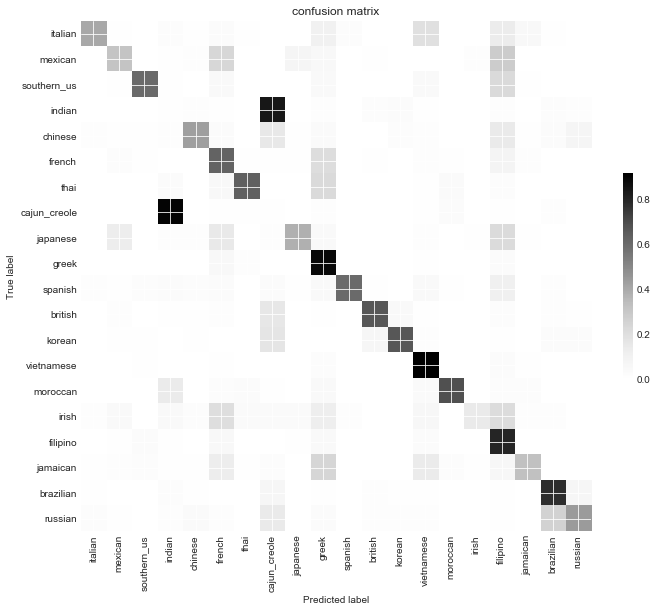

In [67]:
check_accuracy_dev_set()